# Cat Boost for default prediction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gaarutyunov/credit-risk/blob/master/notebooks/colab_cat_boost.ipynb)

## Environment settings

For better performance change Colab runtime type to GPU

In [ ]:
!git clone https://github.com/gaarutyunov/credit-risk.git

In [ ]:
%cd credit-risk

In [ ]:
!pip install -r requirements.txt

To get username and key follow instructions in [readme](https://github.com/Kaggle/kaggle-api)

In [ ]:
%env KAGGLE_USERNAME=<username>
%env KAGGLE_KEY=<password>

In [6]:
!kaggle datasets download wordsforthewise/lending-club

 98% 1.24G/1.26G [00:04<00:00, 282MB/s]
100% 1.26G/1.26G [00:05<00:00, 269MB/s]


In [7]:
!unzip lending-club.zip

Archive:  lending-club.zip
  inflating: accepted_2007_to_2018Q4.csv.gz  
  inflating: accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv  
  inflating: rejected_2007_to_2018Q4.csv.gz  
  inflating: rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv  


In [8]:
!mkdir data

In [9]:
!mv accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv data/accepted_2007_to_2018Q4.csv
!mv rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv data/rejected_2007_to_2018Q4.csv

## Preprocessing

In [10]:
from pipeline import get_preprocessing_pipeline

preprocessing = get_preprocessing_pipeline(
    name='cat_boost',
    debug=True
)

_target_: pipeline.make_preprocessing_pipeline
steps_config:
- CSVReader:
    _target_: pipeline.CSVReader
    file: data/accepted_2007_to_2018Q4.csv
    columns:
    - loan_amnt
    - term
    - int_rate
    - emp_title
    - emp_length
    - home_ownership
    - annual_inc
    - verification_status
    - loan_status
    - purpose
    - addr_state
    - dti
    - earliest_cr_line
    - fico_range_high
    - inq_last_6mths
    - revol_bal
    - initial_list_status
    - out_prncp
    - total_rec_late_fee
    - collection_recovery_fee
    - last_fico_range_low
    - collections_12_mths_ex_med
    - application_type
    - tot_coll_amt
    - avg_cur_bal
    - bc_open_to_buy
    - chargeoff_within_12_mths
    - delinq_amnt
    - mo_sin_old_il_acct
    - mo_sin_old_rev_tl_op
    - mo_sin_rcnt_tl
    - mort_acc
    - mths_since_recent_bc
    - num_accts_ever_120_pd
    - num_actv_bc_tl
    - num_bc_tl
    - num_il_tl
    - num_sats
    - num_tl_120dpd_2m
    - num_tl_30dpd
    - num_tl_90g_d

In [11]:
X = preprocessing.fit_transform([], y=[])
y = preprocessing.label_transformer.label

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 49.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42, shuffle=True)

## Training

To train with CPU remove overrides

In [13]:
from pipeline import get_classifier_pipeline

classifier = get_classifier_pipeline(
    name='cat_boost',
    overrides=[
        '+classifier_pipeline.steps_config.0.Classifier.task_type=GPU'
    ],
    debug=True
)

_target_: pipeline.make_classifier_pipeline
steps_config:
- Classifier:
    _target_: catboost.CatBoostClassifier
    iterations: 1000
    learning_rate: 0.001
    cat_features:
    - term
    - emp_title
    - emp_length
    - home_ownership
    - verification_status
    - purpose
    - addr_state
    - earliest_cr_line
    - initial_list_status
    - application_type
    - disbursement_method
    task_type: GPU



In [14]:
classifier.fit(X_train, y_train)

0:	learn: 0.6909735	total: 143ms	remaining: 2m 22s
1:	learn: 0.6888112	total: 270ms	remaining: 2m 14s
2:	learn: 0.6866569	total: 387ms	remaining: 2m 8s
3:	learn: 0.6844805	total: 495ms	remaining: 2m 3s
4:	learn: 0.6823516	total: 605ms	remaining: 2m
5:	learn: 0.6801989	total: 714ms	remaining: 1m 58s
6:	learn: 0.6780483	total: 825ms	remaining: 1m 57s
7:	learn: 0.6759340	total: 931ms	remaining: 1m 55s
8:	learn: 0.6738146	total: 1.05s	remaining: 1m 55s
9:	learn: 0.6717224	total: 1.16s	remaining: 1m 54s
10:	learn: 0.6696055	total: 1.27s	remaining: 1m 54s
11:	learn: 0.6675140	total: 1.38s	remaining: 1m 53s
12:	learn: 0.6654194	total: 1.5s	remaining: 1m 53s
13:	learn: 0.6633810	total: 1.61s	remaining: 1m 53s
14:	learn: 0.6615012	total: 1.72s	remaining: 1m 52s
15:	learn: 0.6594798	total: 1.83s	remaining: 1m 52s
16:	learn: 0.6574128	total: 1.94s	remaining: 1m 52s
17:	learn: 0.6553763	total: 2.05s	remaining: 1m 52s
18:	learn: 0.6533342	total: 2.17s	remaining: 1m 51s
19:	learn: 0.6512971	total: 2

Pipeline(memory='./.cache/classifier',
         steps=[('Classifier',
                 <catboost.core.CatBoostClassifier object at 0x7f82ae6f28d0>)])

In [15]:
y_pred = classifier.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.949145036898171

In [17]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.8957244043134043

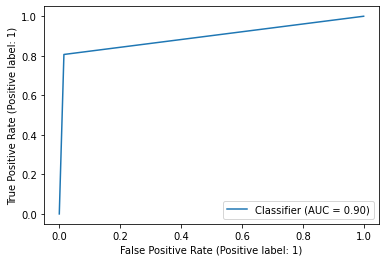

In [18]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_pred)

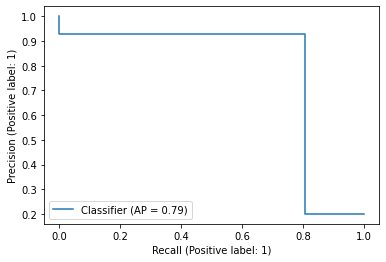

In [19]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_test, y_pred)

In [20]:
from sklearn.metrics import average_precision_score

average_precision_score(y_test, y_pred)

0.7889079904963417

In [ ]:
classifier.steps[0][1].save_model('models/cat_boost')